In [74]:
# her we have the core libraries
import numpy as np
import pandas as pd
import os
import cv2
from collections import Counter
# and her the visulization one
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots  
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

# her we have the machine learning and preprocessing things
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
# the tensorflow and keras for the CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD , Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121, VGG16, InceptionV3
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

#imahe processing
from PIL import Image
import albumentations as A
# utility Libraries
import time
import logging
import gc
# system Librarie
import sys

import warnings

warnings.filterwarnings("ignore")

In [75]:

full_df_file = "eye_disease_detection_dataset/archive/full_df.csv"
df = pd.read_csv(full_df_file)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [34]:
photo_counts = df['Left-Fundus'].value_counts()

# Filter names that appear more than once
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()

len(photo_more_than_once)



3034

In [33]:
photo_more_than_once[2]

'4689_left.jpg'

In [76]:
nested_odir_path = 'eye_disease_detection_dataset/archive/ODIR-5K/ODIR-5K/'

main_files = os.listdir(nested_odir_path)
print("Main ODIR-5K folder contents:")
print(main_files)

# List the contents of the testing_images and training_images folders
testing_images_path = os.path.join(nested_odir_path, 'Testing Images')
training_images_path = os.path.join(nested_odir_path, 'Training Images')

print("\nTesting images folder contents:")
print(os.listdir(testing_images_path)[:10])  # Display first 10 files/directories

print("\nTraining images folder contents:")
print(os.listdir(training_images_path)[:10])

Main ODIR-5K folder contents:
['data.xlsx', 'Testing Images', 'Training Images']

Testing images folder contents:
['1000_left.jpg', '1000_right.jpg', '1001_left.jpg', '1001_right.jpg', '1002_left.jpg', '1002_right.jpg', '1003_left.jpg', '1003_right.jpg', '1004_left.jpg', '1004_right.jpg']

Training images folder contents:
['0_left.jpg', '0_right.jpg', '1005_left.jpg', '1005_right.jpg', '1006_left.jpg', '1006_right.jpg', '1008_left.jpg', '1008_right.jpg', '100_left.jpg', '100_right.jpg']


In [77]:
preprocessed_path = "eye_disease_detection_dataset/archive/preprocessed_images/"
preprocessed_files = os.listdir(preprocessed_path)
print(f"Number of files in preprocessed_images folder: {len(preprocessed_files)}")

# Display first few files
print("Sample files from preprocessed_images folder:")
print(preprocessed_files[:10])

Number of files in preprocessed_images folder: 6392
Sample files from preprocessed_images folder:
['0_left.jpg', '0_right.jpg', '1005_right.jpg', '1006_left.jpg', '1006_right.jpg', '1008_left.jpg', '1008_right.jpg', '100_left.jpg', '100_right.jpg', '1010_left.jpg']


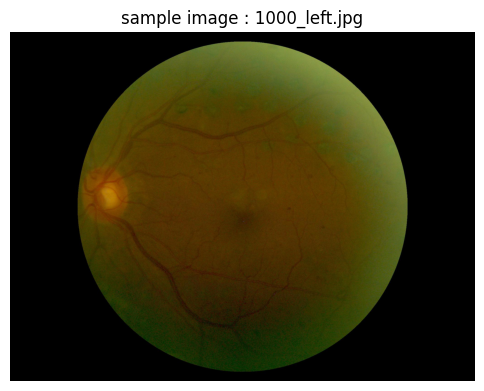

In [ ]:
def get_image_file_path(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            return file_path
    return None

# get a valid image file path from testing_images
sample_testing_image_path = get_image_file_path(testing_images_path)
if sample_testing_image_path:
    sample_testing_image = Image.open(sample_testing_image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(sample_testing_image)
    plt.title(f"sample image : {os.path.basename(sample_testing_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print("no valid image files found in testing_images")

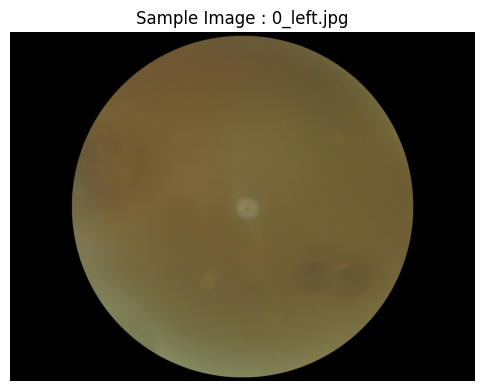

In [ ]:
# get a valid image file path from training_images
sample_training_image_path = get_image_file_path(training_images_path)
if sample_training_image_path:
    sample_training_image = Image.open(sample_training_image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(sample_training_image)
    plt.title(f"Sample Image : {os.path.basename(sample_training_image_path)}")
    plt.axis('off')
    plt.show()
else:
    print("No valid image files found in training_images")

the image from ODIR-5K


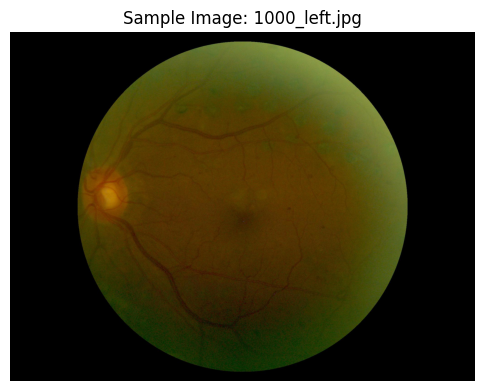

the image from preprocessed_image


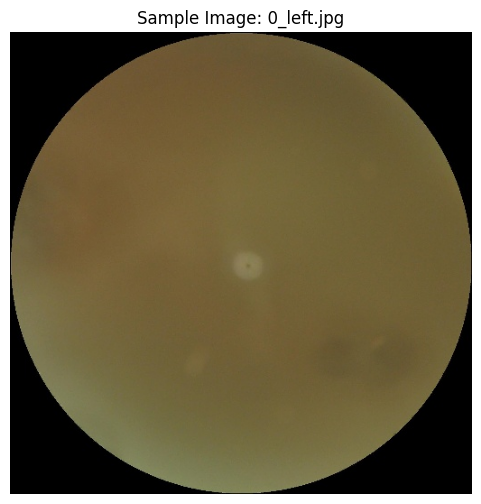

In [80]:
# her we compaer a sample image from the odire-5k and a sample image from prepeocesses_images to see the difrence
def display_sample_image(folder_path, file_name):

    file_path = os.path.join(folder_path, file_name)
    image = Image.open(file_path)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Sample Image: {file_name}")
    plt.axis('off')
    plt.show()

# Display a sample image from ODIR-5K
print("the image from ODIR-5K")
sample_odir_image = os.listdir(testing_images_path)[0]
display_sample_image(testing_images_path, sample_odir_image)

# Display a sample image from preprocessed_images
print("the image from preprocessed_image")
sample_preprocessed_image = os.listdir(preprocessed_path)[0]
display_sample_image(preprocessed_path, sample_preprocessed_image)

In [81]:
# starting with the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [82]:
df.isnull().sum()

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

In [83]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,6392.0,2271.150814,1417.559018,0.0,920.75,2419.5,3294.0,4784.0
Patient Age,6392.0,57.857947,11.727737,1.0,51.00,59.0,66.0,91.0
N,6392.0,0.328692,0.469775,0.0,0.00,0.0,1.0,1.0
D,6392.0,0.332134,0.471016,0.0,0.00,0.0,1.0,1.0
G,6392.0,0.062109,0.241372,0.0,0.00,0.0,0.0,1.0
C,6392.0,0.062891,0.242786,0.0,0.00,0.0,0.0,1.0
A,6392.0,0.049906,0.217768,0.0,0.00,0.0,0.0,1.0
H,6392.0,0.031758,0.175370,0.0,0.00,0.0,0.0,1.0
M,6392.0,0.047872,0.213513,0.0,0.00,0.0,0.0,1.0
O,6392.0,0.248436,0.432139,0.0,0.00,0.0,0.0,1.0


In [84]:
df['Left-Diagnostic Keywords'].nunique()

196

In [85]:
df['Right-Diagnostic Keywords'].nunique()

205

In [86]:
df['Left-Diagnostic Keywords'].value_counts()

Left-Diagnostic Keywords
normal fundus                                                                2796
moderate non proliferative retinopathy                                        717
mild nonproliferative retinopathy                                             428
cataract                                                                      268
pathological myopia                                                           208
                                                                             ... 
epiretinal membrane，epiretinal membrane，lens dust                               1
moderate non proliferative retinopathy，myelinated nerve fibers，laser spot       1
glaucoma，mild nonproliferative retinopathy，macular pigmentation disorder        1
moderate non proliferative retinopathy，suspected glaucoma                       1
glaucoma，wet age-related macular degeneration                                   1
Name: count, Length: 196, dtype: int64

In [87]:
df['Right-Diagnostic Keywords'].value_counts()

Right-Diagnostic Keywords
normal fundus                              2705
moderate non proliferative retinopathy      745
mild nonproliferative retinopathy           472
cataract                                    250
pathological myopia                         216
                                           ... 
suspected abnormal color of  optic disc       1
peripapillary atrophy                         1
anterior segment image                        1
retinal detachment，tessellated fundus         1
central serous chorioretinopathy              1
Name: count, Length: 205, dtype: int64

In [ ]:
#  Calculate percentages for each eye
left_eye_pct = df['Left-Diagnostic Keywords'].str.split(',').explode()
left_eye_pct = left_eye_pct.str.strip().str.lower()
left_eye_pct = (left_eye_pct.value_counts() / len(df) * 100).round(2)

right_eye_pct = df['Right-Diagnostic Keywords'].str.split(',').explode()
right_eye_pct = right_eye_pct.str.strip().str.lower()
right_eye_pct = (right_eye_pct.value_counts() / len(df) * 100).round(2)


#  Create subplots for pie charts
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type':'pie'}, {'type':'pie'}]],
                    subplot_titles=('Left Eye Conditions (%)', 'Right Eye Conditions (%)'))

# Add left eye pie chart
fig.add_trace(
    go.Pie(values=left_eye_pct.values[:10],  # Top 10 conditions
           labels=left_eye_pct.index[:10],
           name="Left Eye",
           hole=0.3,
           textposition='inside',
           textinfo='label+percent'),
    row=1, col=1
)

# Add right eye pie chart
fig.add_trace(
    go.Pie(values=right_eye_pct.values[:10],  # Top 10 conditions
           labels=right_eye_pct.index[:10],
           name="Right Eye",
           hole=0.3,
           textposition='inside',
           textinfo='label+percent'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Distribution of Eye Conditions (%) - Left vs Right Eye",
    height=700,
    showlegend=False
)

fig.show()

In [89]:
print(df["Patient Sex"].value_counts())

Patient Sex
Male      3424
Female    2968
Name: count, dtype: int64


In [90]:
df = df.drop("ID", axis=1)

In [ ]:
#Cardinality changes

df["Patient Sex"].replace({"Male" : 0, "Female": 1})

print(df["Patient Sex"].value_counts())

Patient Sex
Male      3424
Female    2968
Name: count, dtype: int64


<Figure size 2000x3000 with 0 Axes>

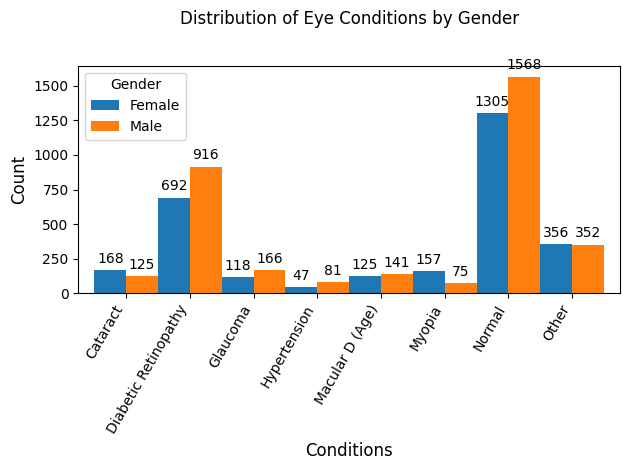


Condition counts by gender:
Gender                Female  Male
Condition                         
Cataract                 168   125
Diabetic Retinopathy     692   916
Glaucoma                 118   166
Hypertension              47    81
Macular D (Age)          125   141
Myopia                   157    75
Normal                  1305  1568
Other                    356   352


In [ ]:
#  Data preparation
# Create a dictionary to map condition codes to full names
condition_names = {
    'N': 'Normal',
    'D': 'Diabetic Retinopathy',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Macular D (Age)',
    'H': 'Hypertension',
    'M': 'Myopia',
    'O': 'Other'
}

# Convert string representation of list to actual list in 'labels' column
labels_list = df['labels'].apply(eval)

# Explode the labels and map to full names
df_exploded = pd.DataFrame({
    'Gender': df['Patient Sex'].repeat(labels_list.str.len()),
    'Condition': [condition_names[item] for sublist in labels_list for item in sublist]
})

#  Create the visualization
plt.figure(figsize=(20, 30))

# Count conditions by gender
condition_counts = df_exploded.groupby(['Condition', 'Gender']).size().unstack()

# Create the grouped bar plot
ax = condition_counts.plot(kind='bar', width=1)

# Customize the plot
plt.title('Distribution of Eye Conditions by Gender', fontsize=12, pad=30)
plt.xlabel('Conditions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Gender')
plt.xticks(rotation=60, ha='right')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.show()

#  Print the actual counts
print("\nCondition counts by gender:")
print(condition_counts)

In [93]:
df.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [94]:
# visulize the distribution of image size on the train images
def get_image_sizes(image_folder): # the function read the image size
    sizes = []
    for file_name in os.listdir(image_folder):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            with Image.open(os.path.join(image_folder, file_name)) as img:
                sizes.append(img.size)
    return sizes

# Get sizes from training images
image_sizes = get_image_sizes('eye_disease_detection_dataset/archive/ODIR-5K/ODIR-5K/Testing Images')
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Plot image sizes distribution
fig = px.histogram(sizes_df, x='Width', nbins=30, title='Distribution of Image Widths')
fig.add_trace(px.histogram(sizes_df, x='Height', nbins=30).data[0])
fig.update_layout(xaxis_title='Pixel Value', yaxis_title='Frequency', barmode='overlay')
fig.show()
# images have difrent size

In [95]:

px.scatter(filtered_df , x = "Left-Diagnostic Keywords"	, y = "Right-Diagnostic Keywords", color = "Patient Sex", animation_frame="Patient Age"
, template= "plotly_dark")



In [96]:
# # classification of the deiseses 
# the custom function for  matching
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'
    elif keyword == 'retinopathy':
        return 'Diabetes'
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'cataract':
        return 'Cataract'
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'pathological myopia':
         return 'Pathological Myopia'
    elif keyword == 'dry age-related macular degeneration':
         return 'Age-related Macular Degeneration'
    elif keyword == 'glaucoma':
        return 'Glaucoma'
    elif keyword == 'drusen':
        return 'Drusen'
    elif keyword == 'hypertensive retinopathy':
         return 'Hypertension'
    else:
        return 'Other diseases/abnormalities'

In [97]:
# apply the costum function to the right the left diagnosis
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact)
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)

# making for them a dataframe
df_right_img = df[['Right-Diagnostic Keywords', 'right_label_column']]
df_left_img  = df[['Left-Diagnostic Keywords', 'left_label_column']]

In [98]:
df_right_img = pd.concat([df_right_img, df[['Right-Fundus']]], axis=1) # concat the df we made with the image id
df_right_img.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_id"}, inplace=True)
df_right_img.drop("Right-Diagnostic Keywords", axis=1, inplace=True) # drop the name
df_left_img = pd.concat([df_left_img, df[['Left-Fundus']]], axis=1) # make same thing with the left
df_left_img.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_id"}, inplace=True)
df_labeled = pd.concat([df_right_img, df_left_img]) # but all in one data set
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)
df_labeled['disease'].value_counts()

disease
Normal Fundus                       5501
Other diseases/abnormalities        3331
Diabetes                            1748
Cataract                             518
Pathological Myopia                  424
Glaucoma                             397
Age-related Macular Degeneration     388
Drusen                               270
Hypertension                         207
Name: count, dtype: int64

In [99]:
df_labeled

,disease,image_id
0,Normal Fundus,0_right.jpg
1,Normal Fundus,1_right.jpg
2,Diabetes,2_right.jpg
3,Other diseases/abnormalities,4_right.jpg
4,Diabetes,5_right.jpg
...,...,...
6387,Diabetes,4686_left.jpg
6388,Diabetes,4688_left.jpg
6389,Other diseases/abnormalities,4689_left.jpg
6390,Other diseases/abnormalities,4690_left.jpg


In [100]:
df_labeled = df_labeled.loc[(df_labeled["disease"] == "Normal Fundus") | (df_labeled['disease'] == 'Cataract') | (df_labeled['disease'] == 'Diabetes') | (df_labeled['disease'] == 'Cataract') |
                           (df_labeled['disease'] == 'Pathological Myopia') | (df_labeled['disease'] == 'Glaucoma') | (df_labeled['disease'] == 'Age-related Macular Degeneration') | (df_labeled['disease'] == 'Drusen') |
                           (df_labeled['disease'] == 'Hypertension') ]

In [101]:
df_labeled['disease'].value_counts() # our job her is done

disease
Normal Fundus                       5501
Diabetes                            1748
Cataract                             518
Pathological Myopia                  424
Glaucoma                             397
Age-related Macular Degeneration     388
Drusen                               270
Hypertension                         207
Name: count, dtype: int64

In [102]:
import shutil

In [103]:
# then now our goal is to store the lables images into its disease folder
main_dir = 'classified_images_new/train'
os.makedirs(main_dir, exist_ok = True)
# make subdirectores for the labels
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(main_dir, label), exist_ok=True)
# the images place
place_imgs = "eye_disease_detection_dataset/archive/preprocessed_images"
# so her we copy the images to the folders
for index , row in df_labeled.iterrows():
    place_file = os.path.join(place_imgs, row["image_id"]) # this is the path for the images in the place_imgs directory
    label = row["disease"]
    im_folder = os.path.join(main_dir, label)
    im_files = os.path.join(im_folder, row["image_id"])
    if not os.path.isfile(place_file):
        print(f"File {place_imgs} does not exist.")
        continue

    shutil.copy2(place_file, im_files) # copy the file


In [104]:
# balance data by oversampling stratgy
train_dir =  "classified_images_new/train"
class_counts_train = {folder: len(os.listdir(os.path.join(train_dir, folder))) for folder in os.listdir(train_dir)}

print("Class counts:")
for label, count in class_counts_train.items(): # her we have the value of data in train is leed the the samples one if you found it the same this mean i run this cell after sampling
    # but the initial value if smaller than this 
    print(f"{label}: {count} images")
    # 100% the data is not balanced

Class counts:
Age-related Macular Degeneration: 196 images
Cataract: 262 images
Diabetes: 889 images
Drusen: 138 images
Glaucoma: 200 images
Hypertension: 104 images
Normal Fundus: 2816 images
Pathological Myopia: 227 images


In [ ]:
#  Set up data generators and constants
IMAGE_SIZE = 224  # EfficientNetB0 default input size
BATCH_SIZE = 32
EPOCHS = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
#  Create data generators
train_generator = train_datagen.flow_from_directory(
    'classified_images_new/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'classified_images_new/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

Found 3869 images belonging to 8 classes.
Found 963 images belonging to 8 classes.


In [ ]:

#  Create the model using transfer learning
def create_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model


In [ ]:
#  Compile and set up callbacks
model = create_model()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#  Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4632 - loss: 1.9084 - val_accuracy: 0.5846 - val_loss: 1.8072 - learning_rate: 0.0010
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5673 - loss: 1.5129 - val_accuracy: 0.5846 - val_loss: 1.8877 - learning_rate: 0.0010
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5741 - loss: 1.4946 - val_accuracy: 0.5846 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5760 - loss: 1.4882 - val_accuracy: 0.5846 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6004 - loss: 1.4501 - val_accuracy: 0.5846 - val_loss: 1.8319 - learning_rate: 2.0000e-04
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5755 - loss: 1.4639 - val_accuracy: 0.5846 - val_loss: 1.7720 - learning_rate: 2.0000e-04
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5786 - 

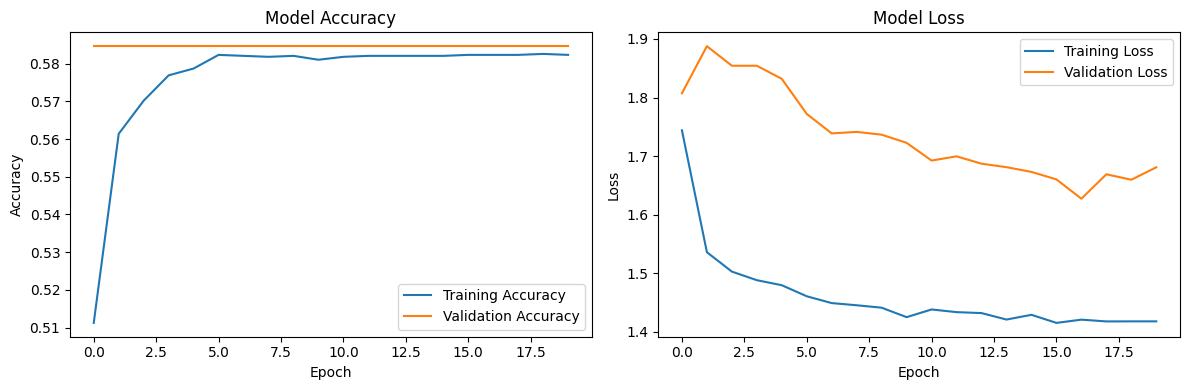

In [ ]:
#  Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Evaluate model performance
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

#  Generate classification report
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 798ms/step - accuracy: 0.5732 - loss: 1.6421
Validation Accuracy: 58.46%
Validation Loss: 1.6270
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 848ms/step

Classification Report:
                                  precision    recall  f1-score   support

Age-related Macular Degeneration       0.00      0.00      0.00        39
                        Cataract       0.00      0.00      0.00        52
                        Diabetes       0.00      0.00      0.00       177
                          Drusen       0.00      0.00      0.00        27
                        Glaucoma       0.00      0.00      0.00        40
                    Hypertension       0.00      0.00      0.00        20
                   Normal Fundus       0.58      1.00      0.74       563
             Pathological Myopia       0.00      0.00      0.00        45

                        accuracy                           0.58       963
                       macro avg       0.07      0.12      0.09 